## Initializations and Presets

To run the code, place the following files in the DATA_FOLDER_PATH:

1. pairsDevTrain.txt
2. pairsDevTest.txt
3. lfw2 folder with the dataset images 

In [1]:
#Presets
SEED                          = 42
USE_GOOGLE_DRIVE_FOR_FILES    = True
DATA_FOLDER_PATH              = "/content/drive/My Drive/Data Science/BGU/Deep Learning/Assignment 2/data/"



import cv2
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as  pd
import os
import json

from sklearn.model_selection      import train_test_split
from sklearn.utils                import shuffle
from sklearn.metrics              import confusion_matrix
from tqdm                         import tqdm
from datetime                     import datetime
from keras.callbacks              import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau#, Callback
from tensorflow.keras.optimizers  import Adam
from keras.models                 import Model, load_model
from keras.initializers           import RandomNormal
from keras.regularizers           import L2
from keras                        import Input, Sequential
from keras.layers                 import Conv2D, MaxPooling2D, Dense, Flatten, Activation, BatchNormalization, Lambda, Subtract, Dropout
from tensorflow.keras             import backend as K
from itertools                    import product

if USE_GOOGLE_DRIVE_FOR_FILES:
  from google.colab import drive
  drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
input_shape = (105, 105)

# Random seed initializations
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


if not os.path.exists(f'{DATA_FOLDER_PATH}results'):
  os.mkdir(f'{DATA_FOLDER_PATH}results')

## Utility functions

In [3]:

def load_data(file_path, images_folder_path, image_size):
  """
  Loads image pairs as ididcated in the file_path text file. 

  Parameters
  ----------
  file_path - str, location of the the pairs text file.
  images_folder_path - str, persons images folder.
  image_size - tuple, image width and hight in pixels. 

  Returns
  -------
  tuple of two numpy array elements. 
  the 1st is a representation of the pairs images, as an array with shape (<number of pairs>, 2, <image width>, <image height>).
  the 2nd is the true values array with shape (<number of pairs>)
  """

  with open(file_path, 'r') as f: 
    pairs_txt = f.read()

  pairs = pairs_txt.split('\n')[1:-1]
  pairs = [p.split('\t') for p in pairs]

  image_path_format = '{}/{}/{}.jpg'

  twin_images = []
  y = []
  for i in tqdm(range(len(pairs)), position=0, leave=True):

    twin_images.append([])
    indices_persons = []
    same_person =  (len(pairs[i])==3)
    y.append(same_person)
    
    indices_persons_0 = [0,1]
    indices_persons_1 = [0, 2] if same_person else [2, 3]

    for person in range(2):
      if person==0:
        person_name = pairs[i][indices_persons_0[0]]
        person_file_number = pairs[i][indices_persons_0[1]]
      else:
        person_name = pairs[i][indices_persons_1[0]]
        person_file_number = pairs[i][indices_persons_1[1]]

      image_path = image_path_format.format(images_folder_path, person_name , person_name + '_' + format(int(person_file_number), '04'))
      twin_images[-1].append(cv2.resize( cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) , image_size))

  return shuffle(np.array(twin_images), np.array(y, dtype=int), random_state=SEED)


def initialize_callbacks(verbose=1):
  """
  Returns the callbacks to be used by the model.

  Parameters
  ----------
  verobse - int, following the keras callbacks verbose logic

  Returns
  -------
  a list of callback objects

  """

  # callback 1: early stopping
  es = EarlyStopping(monitor='val_loss', patience=10, min_delta=0, verbose=verbose, mode="auto")

  # callback 2: reduce learning rate on plateau
  reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=verbose, mode="auto")

  return [es, reduce_lr]
  


def arrange_results(hyp_id, hyp, history, epochs, runtime):
  """
  Prepares a list with the epoch results.

  Parameters
  ----------
  hyp_id - int, the hyper parameter run id.
  hyp - list, , the hyper parameters list.
  history - dict, results of the model fit call.
  epochs - int, the number of planned epochs.
  runtime - int, the fit runtime in seconds.

  Returns
  -------
  results - a list with the epoch results.

  """

  results = []
  results.append(hyp_id)
  results.extend(list(hyp))

  max_val_accuracy_epoch = np.argmax(history.history['val_accuracy'])
  max_val_accuracy = history.history['val_accuracy'][max_val_accuracy_epoch]

  epochs_actual = len(history.history['val_accuracy'])
  results.extend([max_val_accuracy_epoch, max_val_accuracy, epochs, epochs_actual, runtime])

  for k in history.history.keys():
    results.append(history.history[k])

  return results



def save_plot(hyp_id, history, history_test, test_best_score, test_frequency, metric, best_epoch_number, save_folder, legend_loc='lower right'):
  """
  Constructs and saves a plot of train, validation and test.

  Parameters
  ----------
  hyp_id - int, the hyper parameter run id.
  history - dict, results of the model fit call.
  history_test - dict, results of the test evaluation call.
  test_best_score - float, the best results on the test set.
  test_frequency - int, frequency between consecutive test checks during training, or 0 if no checks were done.
  metric - str, the metric that was measured.
  best_epoch_number - int, the epoch number that was chosen to be the best epoch.
  save_folder - str, the folder in which to save the plot.
  legend_loc - str, location of the plot's legend (see matplotlib plot legend locations).

  Returns
  -------
  -

  """

  metric_cap = metric.capitalize()

  plot_data = {}

  plot_data_keys = list(history.keys())
  plot_data_values = list(history.values())

  for i in range(len(plot_data_keys)):
    plot_data[plot_data_keys[i]] = plot_data_values[i]

  num_of_x_values = len(plot_data_values[0])

  fig = plt.figure(figsize = (10, 7))
  plt.plot(np.arange(1,num_of_x_values+1), plot_data[metric])
  plt.plot(np.arange(1,num_of_x_values+1), plot_data[f'val_{metric}'])
  plt.scatter([best_epoch_number+1], test_best_score, s=100, color='green', marker='x')
  if history_test:
    plt.scatter(np.arange(test_frequency,num_of_x_values+1, test_frequency), history_test[f'test_{metric}'], s=50, color='green')
  
  plt.title(f'{metric_cap} per Epoch (Configuration #{hyp_id})')
  plt.ylabel(metric_cap)
  plt.xlabel('Epoch')
  plt.xticks(np.arange(0,num_of_x_values+1,5))

  plt.legend(['train', 'validation', 'test', 'best'], loc=legend_loc)
  plt.savefig(f'{save_folder}/{hyp_id}_{metric}')
  plt.close(fig)


def plot_pairs(X, y_true, indices, proba=None):
  """
  Plots images of the dataset pairs, with a caption that indicates the ground truth value and the prediction score.

  Parameters
  ----------
  X - numpy array of image pairs, with shape (<number of pairs>, 2, <image width>, <image height>).
  y_true - numpy array with the true value per pair.
  indices - numpy array or list, indices in X and y_true to be plotted.
  proba - numpy array or list, predicted probabilities which are the result of the model evaluation on 
          the images indicated in indices. Will be used in the image title. None if no indication is required.  

  Returns
  -------
  -

  """

  fig = plt.figure(figsize = (20, 5))

  for i in range(len(indices)):
    ax = fig.add_subplot(2, len(indices), i+1)
    plt.imshow(X[indices[i]][0], cmap='gray')
    title = f"{indices[i]}: true={y_true[indices[i]]}"
    if proba!=None:
      title += f' pred={proba[i]:.3f}'
    plt.title(title)
    plt.axis('off');

  for i in range(len(indices)):
    ax = fig.add_subplot(2, len(indices), len(indices) + i+1)
    plt.imshow(X[indices[i]][1], cmap='gray')
    plt.axis('off');


## Load data

Copy Zip file from Google drive, and unzip locally

In [4]:
zip_path = DATA_FOLDER_PATH + 'lfwa.zip'
! cp "$zip_path" /content/
! mkdir data
! unzip -q lfwa.zip -d data

Load image pairs as numpy arrays to local objects

In [5]:
images_folder_path = "data/lfw2/lfw2/"

X_train_large, y_train_large = load_data(f"{DATA_FOLDER_PATH}pairsDevTrain.txt", images_folder_path, input_shape)  
X_test, y_test = load_data(f"{DATA_FOLDER_PATH}pairsDevTest.txt", images_folder_path, input_shape)

print("\n\n", X_train_large.shape, X_test.shape)

100%|██████████| 1000/1000 [00:00<00:00, 1486.41it/s]



 (2200, 2, 105, 105) (1000, 2, 105, 105)


Preprocess, split, arrange in pairs

In [6]:
# Scale
X_train_large = X_train_large / 255.0
X_test = X_test / 255.0


# Split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_large, y_train_large, test_size=0.2, random_state=SEED)
print(f"Train: {X_train.shape}\nValid: {X_valid.shape}\nTest: {X_test.shape}")

# Arrange in pairs
pairs_train_large = [X_train_large[:,0], X_train_large[:,1]]
pairs_train = [X_train[:,0], X_train[:,1]]
pairs_valid = [X_valid[:,0], X_valid[:,1]]
pairs_test = [X_test[:,0], X_test[:,1]]
validation_data = (pairs_valid, y_valid)


Train: (1760, 2, 105, 105)
Valid: (440, 2, 105, 105)
Test: (1000, 2, 105, 105)


Randomly check some images and the ground truth values

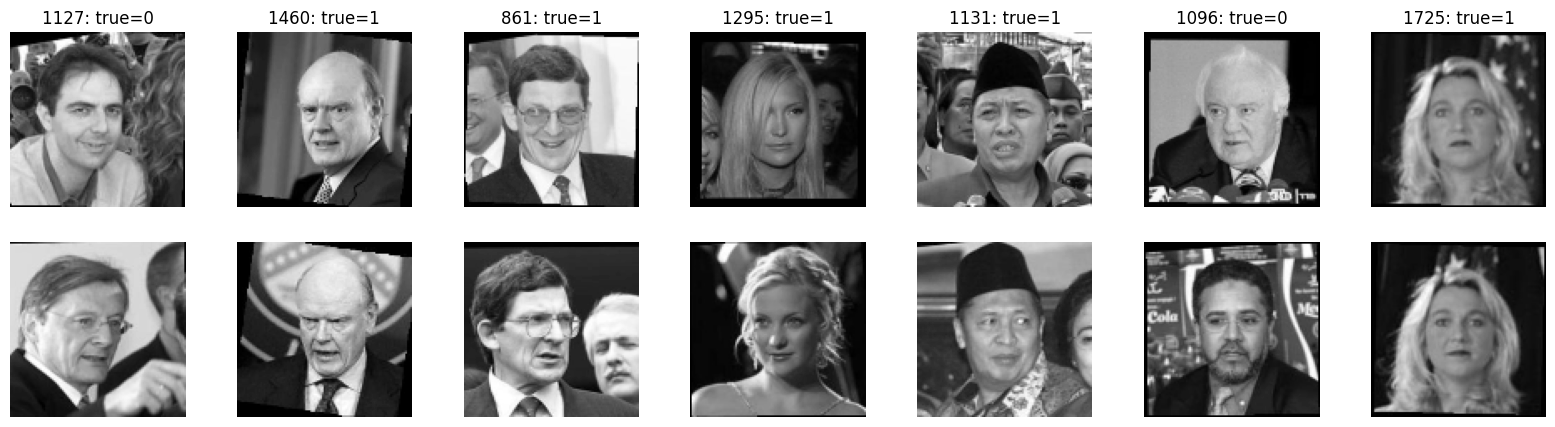

In [6]:
plot_pairs(X_train, y_train, np.random.randint(1,len(X_train),7))

## Model

Recreation of the model that was presented in the [paper](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf), with slight modicfications and additions (see report).

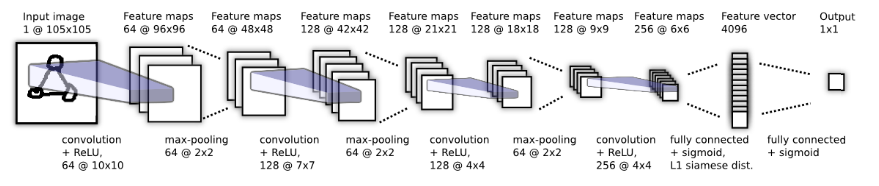

Predict by calculating the distance between the twins

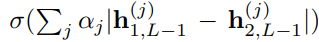

**Model construction functions**

In [37]:
def get_initializers(conv_wnb_distibution):
  """
  
  Parameters
  ----------
  conv_wnb_distibution - dict. weight and bias initialization parameters.

  Returns
  -------
  kernel_initializer - kernel initialization object.
  bias_initializer - bias initialization object.

  """

  w_params, b_params = conv_wnb_distibution.values()
  
  if type(w_params)==list:
    kernel_initializer = RandomNormal(mean=w_params[0], stddev=w_params[1], seed=SEED) 
  else:
    kernel_initializer = w_params

  if type(b_params)==list:
    bias_initializer = RandomNormal(mean=b_params[0], stddev=b_params[1], seed=SEED) 
  else:
    bias_initializer = b_params

  return kernel_initializer, bias_initializer



def conv_layer(model, filters, kernel_size, activation, wnb_distibution, apply_max_pooling, apply_regularization, name_suffix):
  """
  
  Adds a set of Conv2D, BatchNormalization, Activation and MaxPooling2D layers.

  Parameters
  ----------
  model - a keras Sequential model. 
  filters - int,  the number of filters in the convolution.
  kernel_size - tuple of 2 integers, specifying the height and width of the 2D convolution window.
  activation - str, activation function to use.
  wnb_distibution - dict. weight and bias initialization parameters.
  apply_max_pooling - bool, indicates whether to add a MaxPooling2D layer with size (2,2) after the convolution layer. 
  apply_regularization - bool, indicates if to apply an L2(0.1) regularization on the convolution layer.
  name_suffix - str, to be used as a suffix to the name of all the convolution layer's sub layers.

  Returns
  -------
  model - a keras Sequential model, which is the result of adding the convolution layer to the originally received model. 

  """

  kernel_initializer, bias_initializer = get_initializers(wnb_distibution)

  model.add(Conv2D( filters, 
                    kernel_size, 
                    activation=None, 
                    kernel_initializer=kernel_initializer, 
                    bias_initializer=bias_initializer,
                    kernel_regularizer=L2(0.1) if apply_regularization else None,
                    bias_regularizer=L2(0.1) if apply_regularization else None,
                    activity_regularizer=L2(0.1) if apply_regularization else None,
                    name=f'{name_suffix}_conv'))
  
  model.add(BatchNormalization(name=f'{name_suffix}_batchnorm'))

  model.add(Activation(activation, name=f'{name_suffix}_activation'))

  if apply_max_pooling:
    model.add(MaxPooling2D((2,2), padding='valid', name=f'{name_suffix}_pool'))

  return model



def shared_network(conv_kernels, conv_filters, conv_max_pools, conv_wnb_distibution, fc_wnb_distibution, fc_drop_out, apply_regularization):
  """
  Constructs a model as a series of convolutions followed by a fully connected layer.

  Parameters
  ----------
  conv_kernels - list of tuples of 2 integers, representing the height and width of the network's convolutions.
  conv_filters - list of ints, representing the number of filters in the network's convolutions.
  conv_max_pools - list of bools, inidicating if to add a MaxPooling2D layer with size (2,2) after each of the convolution layers. 
  conv_wnb_distibution - list of dicts, indicating the weight and bias initialization parameters for each convolution layer.
  fc_wnb_distibution - list of dicts, indicating the weight and bias initialization parameters for the fully connected layer.
  fc_drop_out - list of floats, indicating the dropout ratio for the fully connected layer.
  apply_regularization - list of bools, indicating if to apply an L2(0.1) regularization on both the convolution and the fully connected layers.

  Returns
  -------
  model - a keras Sequential model. 

  """

  model = Sequential()
   
  for i in range(len(conv_filters)):
    model = conv_layer(model, conv_filters[i], conv_kernels[i], 'relu', conv_wnb_distibution, conv_max_pools[i], apply_regularization, i)
  
  model.add(Flatten(name=f'flatten'))

  kernel_initializer, bias_initializer = get_initializers(fc_wnb_distibution)

  model.add(Dense(4096,
                  name=f'dense',
                  kernel_initializer=kernel_initializer, 
                  bias_initializer=bias_initializer,
                  kernel_regularizer=L2(0.1) if apply_regularization else None,
                  bias_regularizer=L2(0.1) if apply_regularization else None,
                  activity_regularizer=L2(0.1) if apply_regularization else None
                  )
  )

  if fc_drop_out:
    model.add(Dropout(rate=fc_drop_out, seed=SEED))

  return model



def create_model(conv_config, conv_wnb_distibution, fc_wnb_distibution, fc_drop_out, apply_regularization):
  """
  Creates a siamese network.
  
  Parameters
  ----------
  conv_config - dict of kernelsm filters and max pools, for the series of convolution layer.
  conv_wnb_distibution - list of dicts, indicating the weight and bias initialization parameters for each convolution layer.
  fc_wnb_distibution - list of dicts, indicating the weight and bias initialization parameters for the fully connected layer.
  fc_drop_out - list of floats, indicating the dropout ratio for the fully connected layer.
  apply_regularization - list of bools, indicating if to apply an L2(0.1) regularization on both the convolution and the fully connected layers.

  Returns
  -------
  model - a keras Sequential model, initialized with the model inputs and outpus.

  """

  conv_kernels, conv_filters, conv_max_pools = conv_config.values()
  shared_model = shared_network(conv_kernels, conv_filters, conv_max_pools, conv_wnb_distibution, fc_wnb_distibution, fc_drop_out, apply_regularization)

  input_t1 = Input(shape=(input_shape[0], input_shape[1], 1))
  input_t2 = Input(shape=(input_shape[0], input_shape[1], 1))

  # apply the shared model on each of the twin inputs
  t1 = shared_model(input_t1)
  t2 = shared_model(input_t2)

  # calculate the distance between the shared results, and make the binary prediction
  distance = Lambda(lambda x: K.abs(x[0] - x[1]))([t1, t2])
  outputs = Dense(1, activation='sigmoid', name='final_dense')(distance)

  return Model(inputs=[input_t1,input_t2], outputs=outputs)


## Experiments

In [17]:
# load previous results in case of an interrupted run
if os.path.exists(f'{DATA_FOLDER_PATH}results/results.csv'):
  results = pd.read_csv(f'{DATA_FOLDER_PATH}results/results.csv')
  results = results.values.tolist()
  start_from = len(results)
else:
  results = []
  start_from = 0
 
results_columns = ['hyp_id', 
                   'batch_size', 'learning_rate', 'fc_drop_out', 'conv_wnb_distibution', 'fc_wnb_distibution', 'conv_config', 'apply_regularization',
                  'max_val_accuracy_epoch', 'max_val_accuracy', 'epochs', 'epochs_actual', 'runtime', 
                  'history_loss', 'history_accuracy', 'history_val_loss', 'history_val_accuracy']

In [ ]:
epochs = 30

# define the hyperparameter space

batch_sizes           = [8, 16, 32, 64]
learning_rates        = [1e-3, 1e-4, 5*1e-5, 1e-5]
fc_drop_outs          = [0, 0.2, 0.3]
conv_wnb_distibutions = [ 
                        {'w':[0.0, 0.01], 'b':[0.5, 0.01]}, 
                        {'w':'glorot_uniform', 'b':'zeros'}
                         ]
fc_wnb_distibutions   = [ 
                        {'w':[0.0, 0.2], 'b':[0.5, 0.01]}, 
                        {'w':'glorot_uniform', 'b':'zeros'}
                         ]
conv_configs          = [
                        {'kernels': [(10,10),(7,7),(4,4),(4,4)], 'filters': [64, 128, 128, 256], 'max_pools': [True, True, True, False]},
                        {'kernels': [(3,3),(3,3),(3,3),(3,3)],   'filters': [64, 128, 128, 256], 'max_pools': [True, True, True, True]}
                         ]
apply_regularizations = [False, True]


hyp_space = list(product(batch_sizes, learning_rates, fc_drop_outs, conv_wnb_distibutions, fc_wnb_distibutions, conv_configs, apply_regularizations))

print('hyperparameter space size:', len(hyp_space))
if start_from:
  print("starting from hyp_id", start_from)
print('time, hyp_id, batch_size, learning_rate, fc_drop_out, conv_wnb_distibution, fc_wnb_distibution, conv_config, apply_regularization:')



for hyp_id in range(start_from, len(hyp_space)):

  # extract hyperparameters
  hyp = hyp_space[hyp_id]
  batch_size, learning_rate, fc_drop_out, conv_wnb_distibution, fc_wnb_distibution, conv_config, apply_regularization = hyp
  print(datetime.now().strftime("%H:%M:%S"), hyp_id, batch_size, learning_rate, fc_drop_out, conv_wnb_distibution, fc_wnb_distibution, conv_config, apply_regularization)
  
  # create and compile model
  optimizer = Adam(learning_rate=learning_rate)
  model = create_model(conv_config, conv_wnb_distibution, fc_wnb_distibution, fc_drop_out, apply_regularization)
  model.compile(optimizer=optimizer,  loss='binary_crossentropy', metrics=['accuracy'])

  # train
  callbacks = initialize_callbacks(verbose=0)
  start_run = datetime.now()  
  history = model.fit(x=pairs_train, y=y_train, batch_size=batch_size, epochs=epochs, 
                      validation_data=validation_data, callbacks=callbacks, verbose=0)
  runtime = (datetime.now() - start_run).seconds
  
  # save history
  history.history.pop('lr')
  with open(f'{DATA_FOLDER_PATH}results/history_{hyp_id}.json', 'w') as f:
    json.dump(history.history, f)

  # save results
  results.append(arrange_results(hyp_id, hyp, history, epochs, runtime))
  pd.DataFrame(results, columns=results_columns).to_csv(f'{DATA_FOLDER_PATH}results/results.csv', index=False)


## Test set evaluation

Evaluate the test set over the top 3 performing configurations

In [10]:
results_df = pd.DataFrame(results, columns=results_columns).sort_values(by='max_val_accuracy', ascending=False).head(3)
results_df

,hyp_id,batch_size,learning_rate,fc_drop_out,conv_wnb_distibution,fc_wnb_distibution,conv_config,apply_regularization,max_val_accuracy_epoch,max_val_accuracy,epochs,epochs_actual,runtime,history_loss,history_accuracy,history_val_loss,history_val_accuracy
52,52,8,0.0001,0.0,"{'w': [0.0, 0.01], 'b': [0.5, 0.01]}","{'w': 'glorot_uniform', 'b': 'zeros'}","{'kernels': [(10, 10), (7, 7), (4, 4), (4, 4)]...",False,5,0.765909,30,12,25,"[1.0278170108795166, 0.7199472784996033, 0.396...","[0.5727272629737854, 0.7022727131843567, 0.845...","[0.703407347202301, 0.6516211628913879, 0.8014...","[0.6159090995788574, 0.6931818127632141, 0.668..."
244,244,16,0.0001,0.0,"{'w': [0.0, 0.01], 'b': [0.5, 0.01]}","{'w': 'glorot_uniform', 'b': 'zeros'}","{'kernels': [(10, 10), (7, 7), (4, 4), (4, 4)]...",False,5,0.754545,30,12,18,"[0.8813126087188721, 0.48581647872924805, 0.17...","[0.574431836605072, 0.7869318127632141, 0.9323...","[0.6744048595428467, 0.6142069101333618, 0.655...","[0.6136363744735718, 0.668181836605072, 0.7136..."
60,60,8,0.0001,0.0,"{'w': 'glorot_uniform', 'b': 'zeros'}","{'w': 'glorot_uniform', 'b': 'zeros'}","{'kernels': [(10, 10), (7, 7), (4, 4), (4, 4)]...",False,9,0.752273,30,11,24,"[0.9483282566070557, 0.5306671261787415, 0.195...","[0.5857954621315002, 0.7795454263687134, 0.920...","[0.6875150799751282, 0.7260773181915283, 0.786...","[0.6159090995788574, 0.6795454621315002, 0.713..."


For each of these 3, train on the full set (train+validation), until the best epoch

In [ ]:
test_scores=[]
hyp_columns = ['hyp_id', 'learning_rate', 'batch_size', 'conv_config', 'conv_wnb_distibution',  'fc_wnb_distibution', 'fc_drop_out', 'apply_regularization', 'max_val_accuracy_epoch']

for index, row in results_df.iterrows():

  # extract hyperparameters
  hyp_id, learning_rate, batch_size, conv_config, conv_wnb_distibution, fc_wnb_distibution, fc_drop_out, apply_regularization, best_epoch = row[hyp_columns]

  # str to dict
  conv_config = eval(str(conv_config))
  conv_wnb_distibution = eval(str(conv_wnb_distibution))
  fc_wnb_distibution = eval(str(fc_wnb_distibution))

  # create and compile model 
  optimizer = Adam(learning_rate=learning_rate)
  model = create_model(conv_config, conv_wnb_distibution, fc_wnb_distibution, fc_drop_out, apply_regularization)
  model.compile(optimizer=optimizer,  loss='binary_crossentropy', metrics=['accuracy'])

  # train on train+validation
  model.fit(x=pairs_train_large, y=y_train_large, batch_size=batch_size, epochs=best_epoch+1, verbose=0)
  
  # evaluate
  test_scores = model.evaluate(pairs_test, y_test, verbose=0)

  print(f'hyp_id {hyp_id}: loss={test_scores[0]:.3f}, accuracy={test_scores[1]:.3f}')

  # load the initial train and validation results
  with open(f'{DATA_FOLDER_PATH}results/history_{hyp_id}.json') as f:
    history = json.load(f)

  # save figures
  save_plot(hyp_id, history, [], test_scores[1], 0, 'accuracy', best_epoch, f'{DATA_FOLDER_PATH}results/', legend_loc='lower right')
  save_plot(hyp_id, history, [], test_scores[0], 0, 'loss', best_epoch, f'{DATA_FOLDER_PATH}results/', legend_loc='upper right')

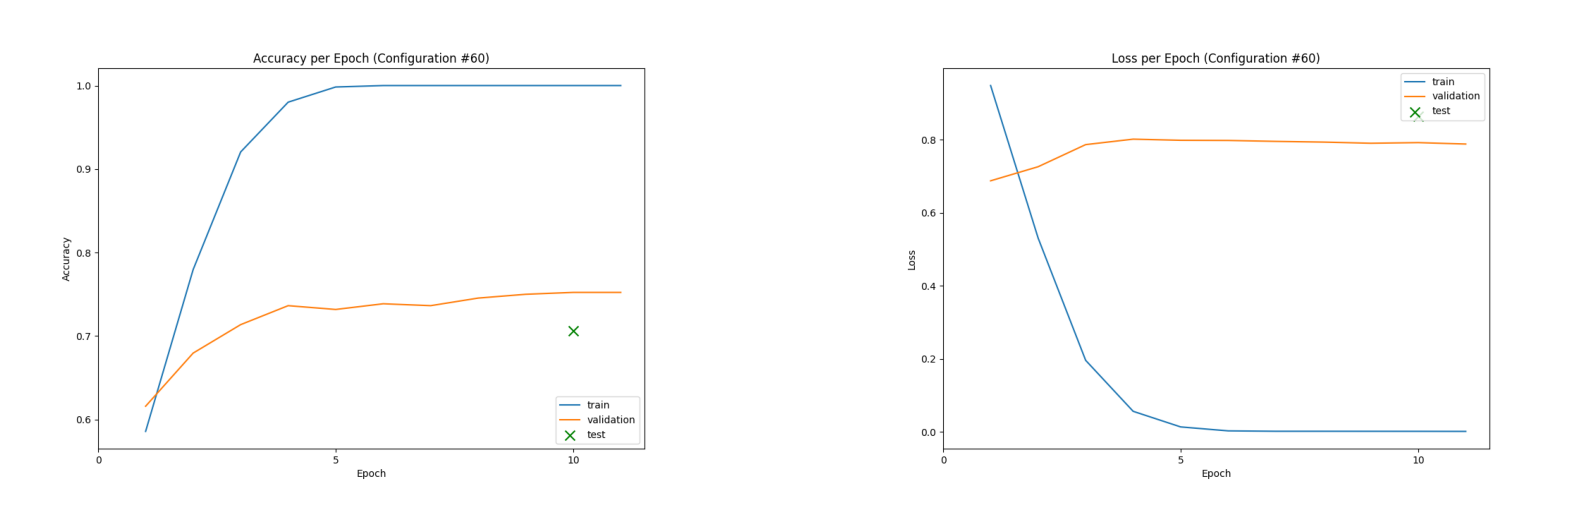

In [14]:
fig = plt.figure(figsize = (20, 10))

ax = fig.add_subplot(1, 2, 1)
img = mpimg.imread(f'{DATA_FOLDER_PATH}results/{hyp_id}_accuracy.png')
imgplot = plt.imshow(img)
plt.axis('off');

ax = fig.add_subplot(1, 2, 2)
img = mpimg.imread(f'{DATA_FOLDER_PATH}results/{hyp_id}_loss.png')
imgplot = plt.imshow(img)
plt.axis('off');


## Best model analysis

Predict

In [62]:
y_pred_proba = model.predict(pairs_test, verbose=0).ravel()
y_pred = np.where(y_pred_proba>0.5, 1, 0)

p_df = pd.DataFrame()
p_df['y_pred_proba'] = y_pred_proba
p_df['y_pred'] = y_pred
p_df['y_true'] = y_test
p_df.head()

,y_pred_proba,y_pred,y_true
0,8.127213e-07,0,0
1,6.400912e-01,1,0
2,1.902195e-01,0,0
3,4.666756e-02,0,0
4,8.976270e-01,1,1


Confusion matrix and probability distribution

In [64]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
cm.columns.name='predicted'
cm.index.name='actual'
cm

predicted,0,1
actual,,
0,350,150
1,141,359


In [80]:
p_df

,y_pred_proba,y_pred,y_true
0,8.127213e-07,0,0
1,6.400912e-01,1,0
2,1.902195e-01,0,0
3,4.666756e-02,0,0
4,8.976270e-01,1,1
...,...,...,...
995,9.104261e-01,1,1
996,6.663004e-01,1,1
997,3.179029e-01,0,0
998,9.379423e-01,1,1


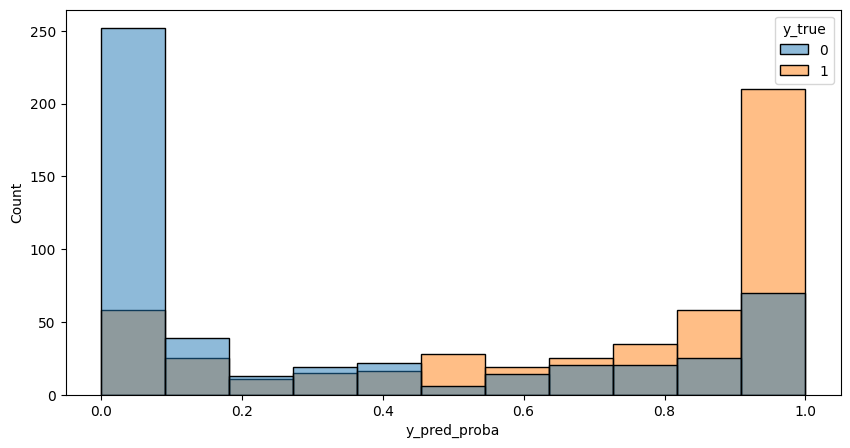

In [81]:
fig = plt.figure(figsize = (10, 5))
splt = sns.histplot(data=p_df, x='y_pred_proba', hue='y_true')

**True Negatives** with highest certainty

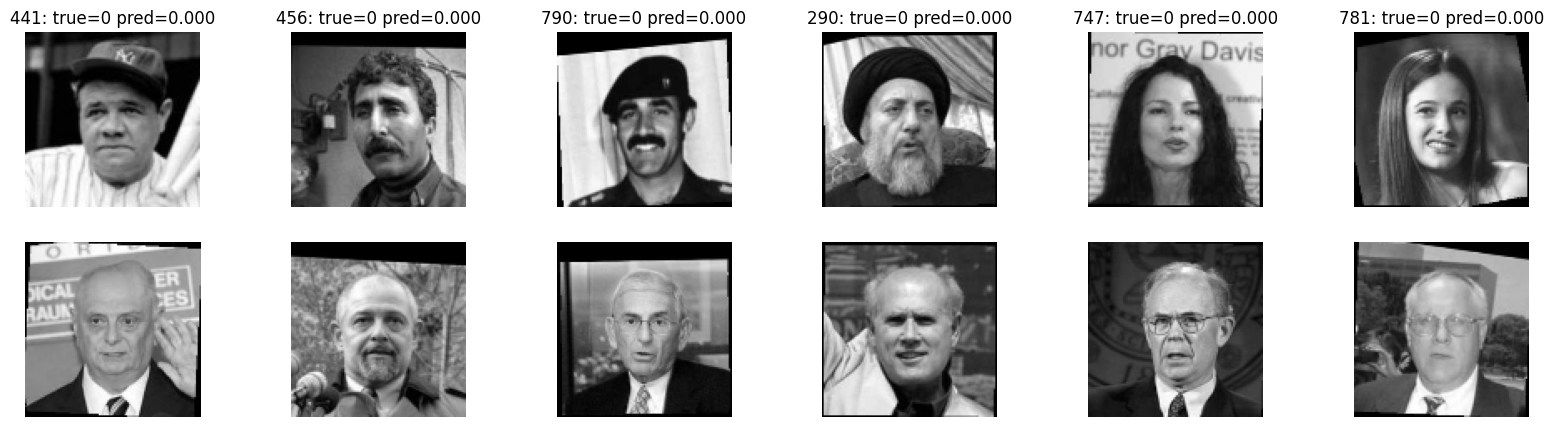

In [65]:
top_tn = p_df[(p_df.y_true==0)&(p_df.y_pred==0)].sort_values(by='y_pred_proba').head(6)

plot_pairs(X_test, y_test, top_tn.index, top_tn.y_pred_proba.values.tolist())


**True Positives** with highest certainty

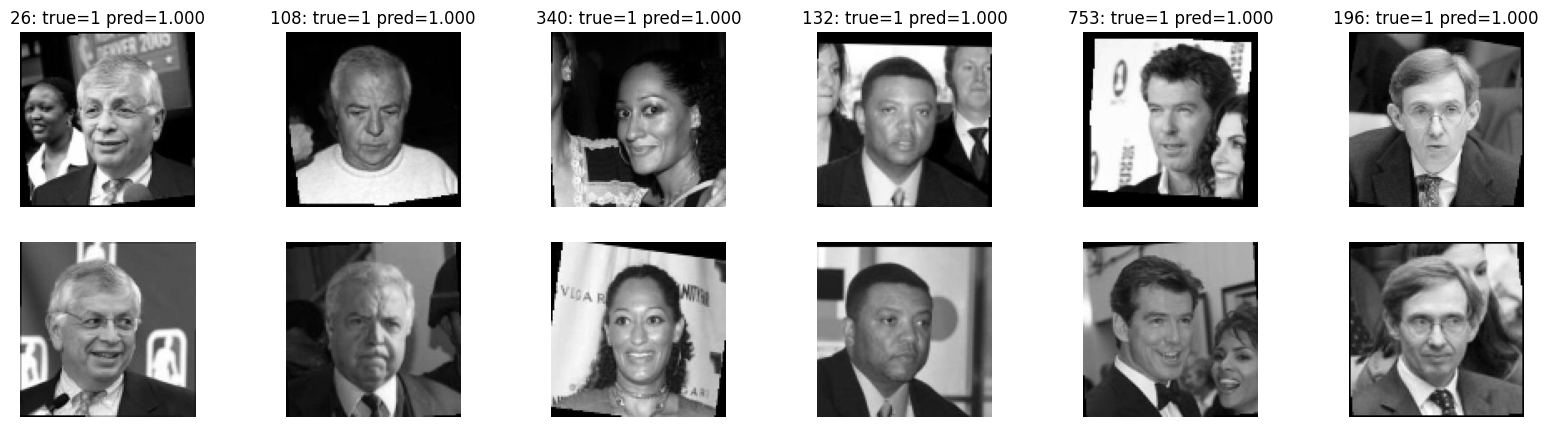

In [66]:
top_tp = p_df[(p_df.y_true==1)&(p_df.y_pred==1)].sort_values(by='y_pred_proba', ascending=False).head(6)

plot_pairs(X_test, y_test, top_tp.index, top_tp.y_pred_proba.values.tolist())


**False Negatives** with highest certainty (biggest mistakes not identifying correct that it is the same person in both images)

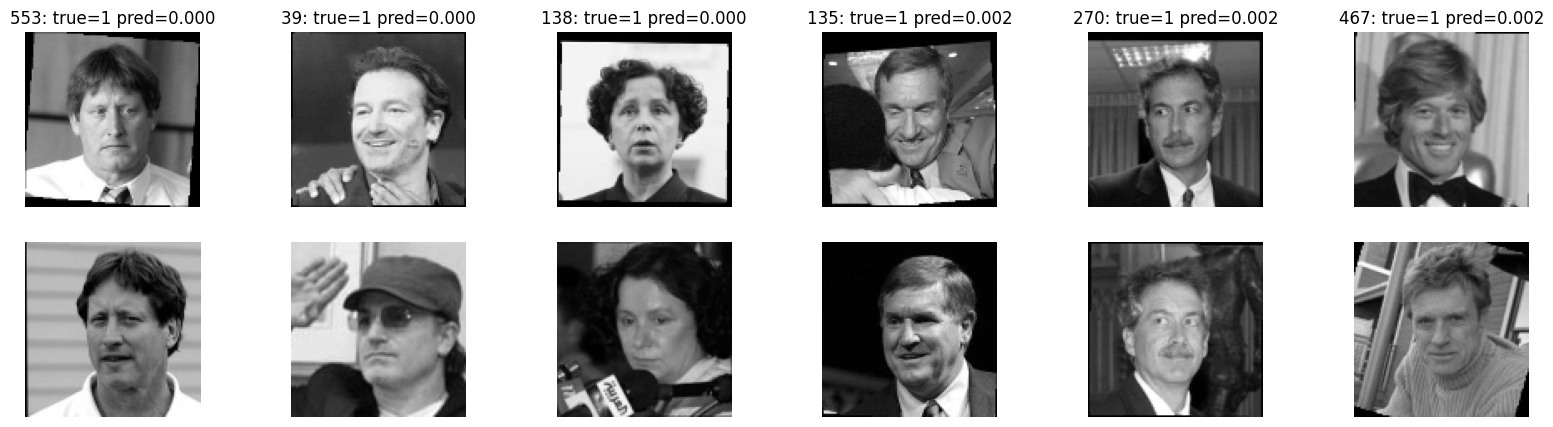

In [67]:
top_fn = p_df[(p_df.y_true==1)&(p_df.y_pred==0)].sort_values(by='y_pred_proba').head(6)

plot_pairs(X_test, y_test, top_fn.index, top_fn.y_pred_proba.values.tolist())


**False Positives** with highest certainty (biggest mistakes not identifying correct that it is NOT the same person in both images)

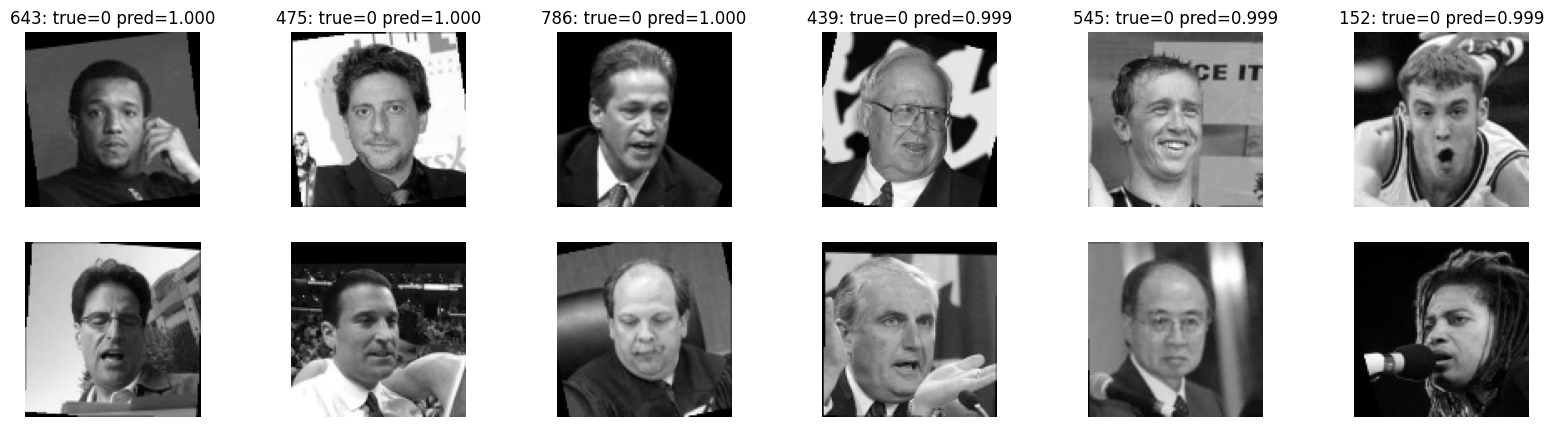

In [68]:
top_fp = p_df[(p_df.y_true==0)&(p_df.y_pred==1)].sort_values(by='y_pred_proba', ascending=False).head(6)

plot_pairs(X_test, y_test, top_fp.index, top_fp.y_pred_proba.values.tolist())
